# Exercise 8
 **Note 1:** Due to compatibility problems on running Netcarto and Informap community detection algorithms, we didn't use these methods on this exercise
 **Note 2:** The calculation with 1000 nodes was taking too much time, so we considered the same amount of nodes as the Girvan Newman benchmark. Then we used 20 values of mu inside the [0,1[ interval.

Import the libraries that we'll use

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community
from networkx.algorithms.community import LFR_benchmark_graph
from community import community_louvain
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import label_propagation_communities
from networkx.algorithms.community import asyn_lpa_communities
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import mutual_info_score
from sklearn.metrics import adjusted_mutual_info_score
import pandas as pd
from IPython.display import display, HTML, display_pretty
import os
np.random.seed(50)

## Benchmark function

In [2]:
# Generate a graph for girvan newman benchmark
def benchmark_girvan_newman(N, mu):
    #N = 128
    tau1 = 3
    tau2 = 1.5
    #mu = 0.04
    k =16
    minc = 32
    maxc = 32
    return LFR_benchmark_graph(n = N, tau1 = tau1, tau2 = tau2, mu = mu, min_degree = k,
                            max_degree = k, min_community=minc, max_community = maxc, seed = 10)

Make community detection functions

In [3]:
# Louvain's community detection method
def detect_communities_louvain(G):
    partition = community_louvain.best_partition(G)
    communities = list()
    for com in set(partition.values()) :
        list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
        communities.append(sorted(list_nodes))
    return sorted(communities)

# Girvan Newman's community detection method
def detect_communities_girvan_newman(G):
    communities = community.girvan_newman(G)
    return sorted(sorted(c) for c in next(communities))

# Fast Greedy community detection method
def detect_communities_greedy(G):
    communities = greedy_modularity_communities(G)
    return sorted(map(sorted, communities))

# Label propagation community detection method
def detect_communities_label_propagation(G):
    communities = list()
    #for c in asyn_lpa_communities(G):
    for c in label_propagation_communities(G):
        communities.append(sorted(c))
    return sorted(communities)

## Function to plot communities

In [4]:
# Plot graph with communities, receives a list of communities, where each community is a list of nodes (ints)
def show_communities(G, communities, name='title'):
    pos=nx.spring_layout(G)
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    plt.figure()
    plt.title(name, fontsize=20)
    aux = 0
    for community in communities:
        nx.draw_networkx_nodes(G, pos, community, node_size = 50, node_color = colors[aux])
        aux = aux + 1
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.show(block=True)

This function will help us to turn the partitions generated by the methods into
 classification lists as explained

In [5]:
# Turn a list of communities, where each community is a list of nodes, into a classification.
#  Classification is a list of classes, where the value v in the position i means that the node
#  i belongs to the community v.
def communitiesToClassification(communities, nNodes):
    # Get number of nodes
    #nNodes = len(G)
    # Initialize a list of size nNodes
    classification = [0]*nNodes
    # Go through the list filling it with the classes
    for i in range(len(communities)):
        for j in communities[i]:
            classification[j] = i
    # Return classification
    return classification

def plotMethod():
    x1 = [1,2,3]
    y1 = [2,4,1]
    # plotting the line 1 points
    plt.plot(x1, y1, label = "line 1")

    # line 2 points
    x2 = [1,2,3]
    y2 = [4,1,3]
    # plotting the line 2 points
    plt.plot(x2, y2, label = "line 2")

    # naming the x axis
    plt.xlabel('x - axis')
    # naming the y axis
    plt.ylabel('y - axis')
    # giving a title to my graph
    plt.title('Two lines on same graph!')

    # show a legend on the plot
    plt.legend()

    # function to show the plot
    plt.show(block=True)

def getClassificationFromNetwork(G):
        # Get the true set of communities
        communities = {frozenset(G.nodes[v]['community']) for v in G}
        communities = sorted(map(sorted, communities))
        # Turn partition into classification
        return communitiesToClassification(communities, len(G))

Now that we did almost everything we'll need, let's call our functions

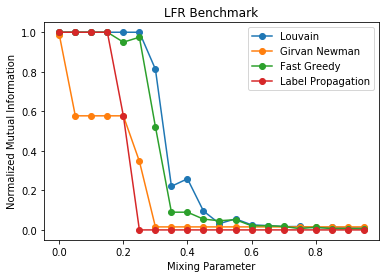

In [6]:
def main():
    nNetworks = 20
    nNodes = 128
    #nNodes = 1000

    # List of method names
    methodNames = [
        'Louvain',
        'Girvan Newman',
        'Fast Greedy',
        'Label Propagation'
    ]

    # List of community detection methods
    methods = [
        detect_communities_louvain,
        detect_communities_girvan_newman,
        detect_communities_greedy,
        detect_communities_label_propagation
    ]

    # Create a dict to store the NMIs for each method
    nmis = dict()
    for methodName in methodNames:
        nmis[methodName] = []

    # Put all network information into a structure
    netInfo = {'muList':[], 'netList':[], 'realClass':[]}

    # For each mu
    for i in range(nNetworks):
        mu = i * 1/nNetworks

        # Append all network information in the structure netInfo
        netInfo['muList'].append(mu)
        netInfo['netList'].append(benchmark_girvan_newman(nNodes, mu))
        netInfo['realClass'].append(getClassificationFromNetwork(netInfo['netList'][i]))

        for j in range(len(methods)):
            # Apply community detection method on graph
            communities = methods[j](netInfo['netList'][i])
            # Turn communities into a classification list
            classification = communitiesToClassification(communities, len(netInfo['netList'][i]))
            # Calculate Normalized Mutual Information
            nmi = normalized_mutual_info_score(netInfo['realClass'][i], classification, average_method='arithmetic')
            # Append NMI
            nmis[methodNames[j]].append(nmi)

    #print(nmis)
    #print(netInfo['muList'])

    # Plot each of the curves
    for methodName in methodNames:
        plt.plot(netInfo['muList'], nmis[methodName], '-o', label=methodName)

    # Naming the x axis
    plt.xlabel('Mixing Parameter')
    # Naming the y axis
    plt.ylabel('Normalized Mutual Information')
    # Giving a title to my graph
    plt.title('LFR Benchmark')
    # Show a legend on the plot
    plt.legend()

    # Save figure
    plt.savefig('lastPlot.png')

    # Plot
    plt.show(block=True)

if __name__ == "__main__":
    main()

Analyzing the graph, we can see a tendency among all the methods. After mu=0.35 there is a sudden fall of the NMI of the methods. We can say that they get way less accurate after this value. A tendency of dump was expected a priori with the increasing of mu. But a hard dump occurs, and this is because at mu=0.5 we have something close to a random graph. So we can expect a fall of the NMI when mu varies from 0 to 0.5, given that at mu=0 we expect 100% accuracy and at mu=0.5 we expect NMI close to 0.